<a href="https://colab.research.google.com/github/ivan74rus/DS/blob/main/ML_%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

DateCrawled — дата скачивания анкеты из базы          
VehicleType — тип автомобильного кузова            
RegistrationYear — год регистрации автомобиля             
Gearbox — тип коробки передач             
Power — мощность (л. с.)                 
Model — модель автомобиля               
Kilometer — пробег (км)           
RegistrationMonth — месяц регистрации автомобиля              
FuelType — тип топлива               
Brand — марка автомобиля            
Repaired — была машина в ремонте или нет               
DateCreated — дата создания анкеты               
NumberOfPictures — количество фотографий автомобиля                  
PostalCode — почтовый индекс владельца анкеты (пользователя)                 
LastSeen — дата последней активности пользователя                

In [2]:
#подключить гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#instal catboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00


In [4]:
# импорты из стандартной библиотеки
import os
import warnings
from copy import deepcopy


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor


In [6]:
# настройки и константы
warnings.filterwarnings("ignore")
LOCAL_DATA_PATH = '/content/drive/MyDrive/DS/'

## Подготовка данных

### Загрузка данных

In [7]:
try:
    df = pd.read_csv(f'{LOCAL_DATA_PATH}autos.csv')
except:
    df = pd.read_csv(f'{os.getcwd()}autos.csv')
    

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
198693,2016-03-25 00:57:20,6499,convertible,1991,manual,113,3er,150000,2,petrol,bmw,NaN,2016-03-24 00:00:00,0,75438,2016-04-06 06:17:21
147382,2016-03-28 19:37:13,11000,wagon,1985,manual,116,passat,70000,1,petrol,volkswagen,no,2016-03-28 00:00:00,0,64673,2016-04-07 01:45:42
151152,2016-03-12 13:46:17,10400,wagon,2008,manual,177,3er,125000,5,gasoline,bmw,no,2016-03-12 00:00:00,0,94107,2016-04-06 20:19:37


### Изучение, обработка данных

Удалим данные никак не свзяаные с ценой авто.     
DateCrawled — дата скачивания анкеты из базы  
DateCreated — дата создания анкеты      
PostalCode — почтовый индекс владельца анкеты (пользователя)    
LastSeen — дата последней активности пользователя   
NumberOfPictures — количество фотографий автомобиля  - на саму цену никак не влияет сколько фото   
Brand - прямая связь с моделью авто, т е для ML это не нужная колонка, 100% корреляция с Model, все модели уникальны для каждого бренда. Но чтобы нам легко орентироваться и анализировать, создаадим новую колнку , объеденив эти две.   
НО! Сделаем это чуть позже, когда NAN заменим, иначе получим NAN + object = NAN

In [11]:
df = df.drop(['DateCrawled','DateCreated','PostalCode', 'LastSeen','NumberOfPictures'], axis=1)

In [12]:
df.shape

(354369, 11)

In [13]:
df.sample(30)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
127655,8500,coupe,2006,manual,241,astra,150000,11,petrol,opel,no
24017,2200,bus,2002,manual,125,zafira,150000,6,petrol,opel,no
279474,500,wagon,1999,manual,110,avensis,150000,4,petrol,toyota,yes
271613,19500,sedan,2006,auto,177,5er,70000,10,petrol,bmw,no
125495,1450,small,2002,manual,60,punto,125000,11,petrol,fiat,no
50726,1990,sedan,2001,manual,120,147,150000,6,petrol,alfa_romeo,no
214037,7700,small,2011,manual,60,polo,80000,12,petrol,volkswagen,no
169434,590,sedan,1999,manual,101,omega,150000,3,gasoline,opel,no
74807,1250,wagon,1999,manual,115,NaN,150000,8,gasoline,volkswagen,no
173355,1200,wagon,2003,manual,90,focus,150000,0,petrol,ford,no


### Price

Проанализируем данные на выбросы. Самый главный столбец это цена , он же таргет.

<AxesSubplot:>

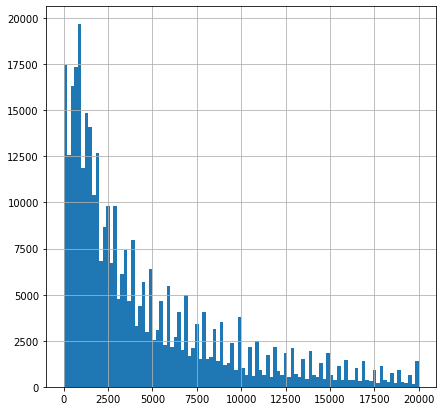

In [17]:
df['Price'].hist(bins=100, figsize=(7,7))

In [18]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [19]:
#нулевые
df[df['Price'] == 0]['Price'].count()

10772

В целом распределение данных близко к нормальному. Есть выбросы - нулевые цены. Цена не может быть нулевой. Их дропнем без сожаления.     
С очень низкой ценой проанализируем дополнительно.

In [20]:
# 5% квантиль снизу отпределим как аномально низкую
df['Price'].quantile(0.05) 

200.0

In [21]:
#c  аномально низкой цценой
df[(df['Price'] <= 200) & (df['Price'] > 0)]['Price'].count()

8676

In [22]:
# посмотрим глазами
df[(df['Price'] < 200) & (df['Price'] > 0)].sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
15123,150,NaN,2000,manual,75,golf,150000,0,NaN,volkswagen,NaN
6029,100,small,1998,manual,0,NaN,70000,1,petrol,suzuki,no
295313,1,sedan,1994,manual,140,3er,150000,0,petrol,bmw,NaN
286928,1,NaN,1000,NaN,174,touareg,5000,3,gasoline,volkswagen,NaN
63385,100,small,1995,manual,54,polo,150000,1,petrol,volkswagen,yes
351256,150,small,1995,manual,74,golf,150000,5,petrol,volkswagen,NaN
218173,175,small,1999,manual,54,corsa,150000,8,petrol,opel,yes
39868,100,NaN,2016,auto,0,astra,150000,0,petrol,opel,NaN
316965,40,NaN,2011,NaN,0,a3,150000,0,NaN,audi,NaN
252752,150,small,1996,manual,52,fiesta,150000,3,petrol,ford,NaN


На взгляд видно,ч то это либо очень старые авто 199х годов, может битые, без документов и тп. В целом все это мусорные данные, которые помещают ML. ОТкинем.

In [23]:
df = df[df['Price'] >= 200]

In [ ]:
df.shape

Теперь посмотрим остальные столбцы на выбросы и аномалии. nan  будем заменять.Т к многим моделям будет мешать он.

### 'VehicleType'

In [24]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

nan заменим на other

In [25]:
df.loc[df['VehicleType'].isna(),'VehicleType'] = 'other'

### 'RegistrationYear'    


In [26]:
df['RegistrationYear'].describe()

count    336907.000000
mean       2003.979947
std          67.938601
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

явные выбросы года слишком низкие и не существующие. Кроме того если авто старый и раритетный, то цена на него индивидаульна, и не может быть определена приложением для которого мы делаем ML. Так что все лишнее отбрасываем.


In [27]:
df[(df['RegistrationYear'] <= 1985) | (df['RegistrationYear'] > 2018)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN
28,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,8,gasoline,mercedes_benz,no
91,1222,sedan,1984,auto,180,other,150000,3,petrol,opel,NaN
220,850,other,1985,manual,54,caddy,150000,0,gasoline,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354037,10500,convertible,1968,manual,54,other,20000,4,NaN,renault,no
354165,8500,coupe,1981,auto,136,other,150000,4,petrol,mercedes_benz,no
354286,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes
354302,5990,bus,1984,auto,0,other,70000,4,petrol,chevrolet,NaN


In [28]:
df.shape

(336907, 11)

In [29]:
df = df.query('2018> RegistrationYear > 1985')

In [30]:
df.shape

(327626, 11)

### Gearbox      
nan заменим на 'nan'

In [31]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [32]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'nan'

In [33]:
df[df['Gearbox'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired


### Power

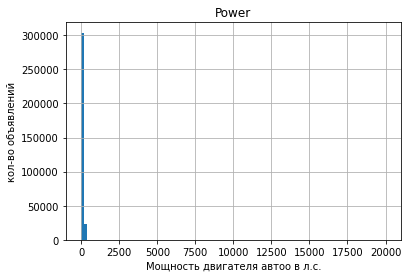

In [34]:
plt.title('Power')
plt.xlabel("Мощность двигателя автоо в л.с.")
plt.ylabel("кол-во объявлений")
df['Power'].hist(bins=100)
plt.show()

In [35]:
df['Power'].describe()

count    327626.000000
mean        112.901394
std         185.323123
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [36]:
#
hight_quant = 0.995
print ('Верхний порог мощности',df['Power'].quantile(hight_quant))
print ('Нижний',df['Power'].quantile(0.05))

Верхний порог мощности 334.0
Нижний 0.0


In [37]:
df[(df['Power'] <= 10) | (df['Power'] > df['Power'].quantile(0.995))]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
32,245,sedan,1994,nan,0,golf,150000,2,petrol,volkswagen,no
37,1500,other,2016,nan,0,kangoo,150000,1,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
354337,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,NaN
354346,2600,other,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no


отбросим выбросы снизу 5% квнтиль это 0 и сверху 1% кватиль  , но так же добавил окло нулевые занчения < 10
Не забываем,что цель приложения не определение цены на уникальные авто(тут к таким отности можно сверх мощные и возможно кране маломощные <10)

In [38]:
df.shape

(327626, 11)

In [39]:
df = df[(df['Power'] > 10) & (df['Power'] <= df['Power'].quantile(hight_quant))]
df.shape

(294477, 11)

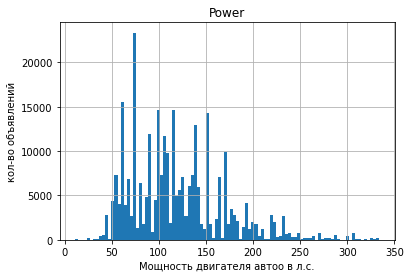

In [40]:
# теперь гисто выглядит лучше
plt.title('Power')
plt.xlabel("Мощность двигателя автоо в л.с.")
plt.ylabel("кол-во объявлений")
df['Power'].hist(bins=100)
plt.show()

### Model & Brand	

In [41]:
df['Model'].nunique()

247

In [42]:
df[df['Model'].isna()].shape

(10784, 11)

заменим текстовыми nan

In [43]:
df.loc[df['Model'].isna(), 'Model'] = 'nan'
df[df['Model'].isna()].shape

(0, 11)

In [44]:
df['Brand'].nunique()

40

In [45]:
df[df['Brand'].isna()].shape

(0, 11)

Теперь объединим модель и брент в одну колонку. Как и было отмечено выше, это связанные колонки. Каждая модель уникальна и не пересекается по брендам. Можно было оставить только модель, но для удобства анализа сложим эти две колонки.

In [46]:
#создаем нов столбец
df['Brand_Model'] = df['Brand'] + '_' + df['Model']
# дропаем 
df = df.drop(['Brand','Model'], axis=1)

In [47]:
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,Brand_Model
1,18300,coupe,2011,manual,190,125000,5,gasoline,yes,audi_nan
2,9800,suv,2004,auto,163,125000,8,gasoline,NaN,jeep_grand
3,1500,small,2001,manual,75,150000,6,petrol,no,volkswagen_golf


### Kilometer

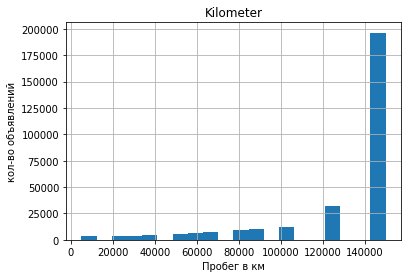

In [48]:
plt.title('Kilometer')
plt.xlabel("Пробег в км")
plt.ylabel("кол-во объявлений")
df['Kilometer'].hist(bins=20)
plt.show()


Похоже в приложении/базе нельзя выставить более 150 000 пробега ),    
странно, но тут с этим ничего не сделать. 

### RegistrationMonth

In [49]:
df['RegistrationMonth'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

0 не может быть ,в году 12 месяцев, заменим  0 на 1

In [50]:
df.loc[df['RegistrationMonth'] == 0 , 'RegistrationMonth'] = 1

In [51]:
df['RegistrationMonth'].nunique()

12

### FuelType	

In [52]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

nan меняем на other

In [53]:
df.loc[df['FuelType'].isna() ,'FuelType'] = 'other'

In [54]:
df['FuelType'].unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Repaired

In [55]:
df['Repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

nan заменим 'nan'. Т е не известо что там, толи битая, то ли нет.

In [56]:
df.loc[df['Repaired'].isna(), 'Repaired'] = 'nan'

In [57]:
df['Repaired'].unique()

array(['yes', 'nan', 'no'], dtype=object)

**Вывод** данные обработаны, отброшены все выбросы, пропусков нет, типы данных ок.

In [58]:
#итого
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294477 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              294477 non-null  int64 
 1   VehicleType        294477 non-null  object
 2   RegistrationYear   294477 non-null  int64 
 3   Gearbox            294477 non-null  object
 4   Power              294477 non-null  int64 
 5   Kilometer          294477 non-null  int64 
 6   RegistrationMonth  294477 non-null  int64 
 7   FuelType           294477 non-null  object
 8   Repaired           294477 non-null  object
 9   Brand_Model        294477 non-null  object
dtypes: int64(5), object(5)
memory usage: 24.7+ MB


Построим диаграммы рассеивания для численных переменных, для более подробного изучения характера взаимосвязи между пременными.

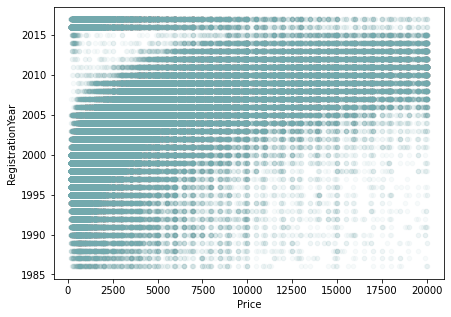

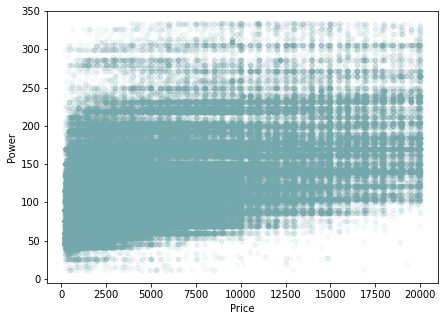

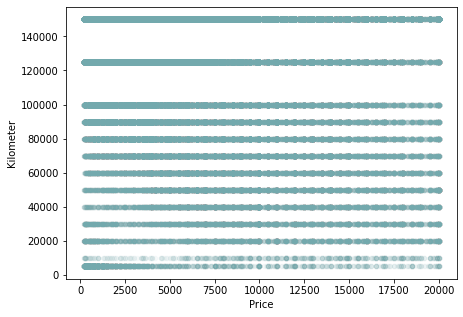

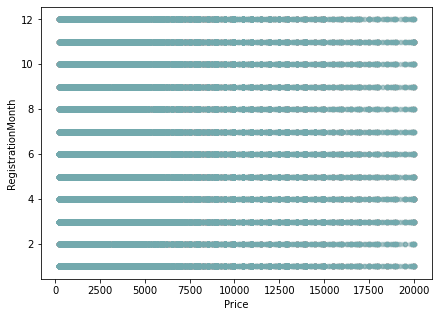

In [59]:
for i in df.drop(['Price'],axis=1).select_dtypes(include='int64').columns.to_list():
    df.plot(x='Price', y=i, kind='scatter', alpha=0.05,figsize=(7, 5), color='#73A9AD')

В целом, на взгляд, особо не прослеживается характер взаимосвязей. Кроме роста цены с более ранним годом и роста цены с боллее мощным двигателем.

## Подготвка выборок для обучения моделей   
Тут кроме разбивки на тест валид трэйн, нужно еще будет провести ohe кодирования для всего кроме КЭтБуст.

In [60]:
#для каждой модели будет свой df, в памяти они немного занимают, так что можно плодить перменные.    
#df базовый его не меняем после обраотки данных.
df_cat = deepcopy(df)
df_lr = deepcopy(df) 
df_lgbm = deepcopy(df) 
 

In [61]:
# функция подготовки df, разбивка на трейн тест валид
def preparation (df):
    # бьем на таргет и фьючи
    target = df['Price']
    features = df.drop(columns='Price')

    # разбиваем выборк на трен, (валид + тест)
    features_train, features_valid_test, target_train, target_valid_test =\
             train_test_split(features, target, test_size=0.4, random_state=12345)
    # разбиваем выборк на валид  и  тест
    features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
    return  features_train, target_train, features_valid, features_test, target_valid, target_test


In [62]:
#тест функции
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df) 
print ("features_train.shape", features_train.shape)
print ("features_valid.shape", features_valid.shape)
print ("features_test.shape", features_test.shape)

features_train.shape (176686, 9)
features_valid.shape (58895, 9)
features_test.shape (58896, 9)


In [63]:
# функция для OHE, сразу 3 датасета получаем
def ohe(features_train, features_valid , features_test):
    #категориальные признаки для OHE кодирования
    ohe_features = features_train.select_dtypes(include='object').columns.to_list()
    
    # игнорируется ранее невстречающиеся значения признака (при transform)
    encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore',  sparse=False)

    # обучаем энкодер на заданных категориальных признаках тренировочной выборки
    encoder_ohe.fit(features_train[ohe_features])

    # добавляем закодированные признаки в features_train, valid, test
    # encoder_ohe.get_feature_names_out() позволяет получить названия колонок
    features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
    features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid[ohe_features])
    features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])

    # удаляем незакодированные категориальные признаки (изначальные колонки)
    features_train = features_train.drop(ohe_features, axis=1)
    features_valid = features_valid.drop(ohe_features, axis=1)
    features_test = features_test.drop(ohe_features, axis=1)    
    
    #проверям
    print ('features_train.shape' ,features_train.shape)
    print ('features_valid.shape' ,features_valid.shape)
    print ('features_test.shape' ,features_test.shape)
    return features_train, features_valid , features_test

In [64]:
%%time
# тест функ ohe
print ('features_train.shape' ,features_train.shape)
print ('features_valid.shape' ,features_valid.shape)
print ('features_test.shape' ,features_test.shape)

features_train, features_valid , features_test = ohe(features_train, features_valid , features_test)

features_train.shape (176686, 9)
features_valid.shape (58895, 9)
features_test.shape (58896, 9)
features_train.shape (176686, 352)
features_valid.shape (58895, 352)
features_test.shape (58896, 352)
CPU times: user 4.39 s, sys: 2.08 s, total: 6.47 s
Wall time: 7.47 s


In [65]:
#датасет для сохранения результатов
stats = pd.DataFrame(columns=['RMSE','time_predict','time_fit'], index = ['LinReg', 'LigtGBM', 'CatBoost'])
stats

,RMSE,time_predict,time_fit
LinReg,NaN,NaN,NaN
LigtGBM,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN


## Обучение моделей

###  LinearRegression
дата сет был подготовлен выше на проверках функций


In [66]:
%%time
lrg = LinearRegression()
lrg.fit(features_train, target_train)

CPU times: user 13.6 s, sys: 1.13 s, total: 14.8 s
Wall time: 10.1 s


LinearRegression()

In [67]:
%%time
lrg_predict = lrg.predict (features_valid)

CPU times: user 167 ms, sys: 75.1 ms, total: 242 ms
Wall time: 166 ms


In [68]:
print ('RMSE',mean_squared_error(target_valid, lrg_predict)**0.5 )

RMSE 2341.693056020263


In [69]:
# Результаты в в таблицу сохраняем
stats.loc['LinReg' , 'RMSE'] = int(mean_squared_error(target_valid, lrg_predict)**0.5)
stats.loc['LinReg' , 'time_predict'] = '15.8 s'
stats.loc['LinReg' , 'time_fit'] = '87 ms'
stats

,RMSE,time_predict,time_fit
LinReg,2341,15.8 s,87 ms
LigtGBM,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN


Казалось бы результат достигнут на ЛинРег, неплохо, но посмотрим распределение..

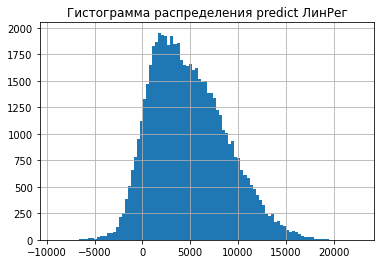

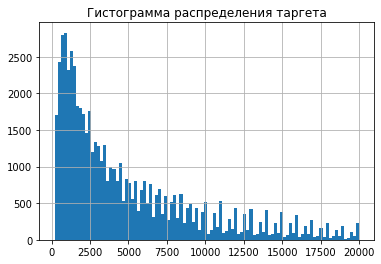

In [70]:
plt.title('Гистограмма распределения predict ЛинРег')
pd.Series(lrg_predict).hist(bins=100)
plt.show()
plt.title('Гистограмма распределения таргета')
target_valid.hist(bins=100)
plt.show()


Все хорошо, кроме отрицательных цен. Но условие проекта выполнено, RMSE < 2500

In [71]:
#Посотмрим значимые фичи
pd.Series(lrg.coef_ , index=features_train.columns ).abs().sort_values(ascending=False).head(10)

Brand_Model_land_rover_defender       10534.058185
Brand_Model_mercedes_benz_g_klasse     9752.902494
Brand_Model_volkswagen_amarok          8869.232774
Brand_Model_porsche_other              8581.456419
Brand_Model_porsche_nan                7845.335861
Brand_Model_porsche_911                7639.876146
Brand_Model_mercedes_benz_gl           7443.310201
Brand_Model_mercedes_benz_glk          7439.304099
Brand_Model_jeep_wrangler              6975.375593
Brand_Model_mercedes_benz_sl           6763.505784
dtype: float64

In [72]:
#Посотмрим НЕ значимые фичи
pd.Series(lrg.coef_ , index=features_train.columns ).abs().sort_values(ascending=False).tail(10)

Brand_Model_hyundai_santa     50.328296
Brand_Model_audi_a8           41.256318
VehicleType_wagon             35.884427
Power                         32.202306
FuelType_petrol               21.678594
Brand_Model_fiat_bravo        11.944533
Brand_Model_volvo_v40          8.501708
RegistrationMonth              8.036394
Brand_Model_daihatsu_cuore     7.632788
Kilometer                      0.033430
dtype: float64

**Вывод** Можно увидеть сразу , что максимальное влияние на цену оказывает модель дорогих авто. Километраж, месяц регистрации, мощность двиг, тип топлива, минимальное влияние. Модель ходовых бюджетных авто тоже мало оказывает влияние на цену. Это все очень совпадает с реальностью.       

Для LinReg нет гиперпараметров для перебора. \Проведем  тест с обработкой фичей и масштабирвоанием

#### Масштабирование численных признаков.

In [73]:
# создаём скелер ,  в датасетах все признаки численные 
scaler = StandardScaler()
scaler_features = df.drop(['Price'],axis=1).select_dtypes(include='int64').columns.to_list()
# обучаем скелер на численных признаках тренировочной выборки
scaler.fit(features_train[scaler_features])

#масштабируем все выборки
features_train[scaler_features] = scaler.transform(features_train[scaler_features])
features_valid[scaler_features] = scaler.transform(features_valid[scaler_features])

In [74]:
%%time
lrg = LinearRegression()
lrg.fit(features_train, target_train)
lrg_predict = lrg.predict (features_valid)
print ('RMSE',mean_squared_error(target_valid, lrg_predict)**0.5 )

RMSE 2341.6930560207657
CPU times: user 12.7 s, sys: 1.68 s, total: 14.4 s
Wall time: 13.3 s


Как видно масштабирование не изменило  метрику качества

#### Проведем тест. Уберем из данных пробег, месяц регистрации, мощность, тип топлива.

In [75]:
df_lr = df_lr.drop(['Kilometer', 'RegistrationMonth','Power', 'FuelType'],axis=1)

In [76]:
df_lr.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Repaired',
       'Brand_Model'],
      dtype='object')

In [77]:
#разбивка и ohe
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df_lr) 
features_train, features_valid , features_test = ohe(features_train, features_valid , features_test)

features_train.shape (176686, 343)
features_valid.shape (58895, 343)
features_test.shape (58896, 343)


In [78]:
%%time
lrg = LinearRegression()
lrg.fit(features_train, target_train)
lrg_predict = lrg.predict (features_valid)


CPU times: user 11.7 s, sys: 2.27 s, total: 14 s
Wall time: 14 s


In [79]:
print ('RMSE', mean_squared_error(target_valid, lrg_predict )**0.5 )

RMSE 2716.4187263057715


**Вывод**  Качество ухудшилось, так что эти  фичи важны, их не откидываем.

### LightGBM   


Подготовим датасет. Категориальные признаки типа object  переведем в 'category' для Light GBM

In [80]:
df_lgbm[df_lgbm.select_dtypes(include='object').columns.to_list()] =\
                   df_lgbm.select_dtypes(include='object').astype('category')


Разбивка на трайн валид тест

In [81]:
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df_lgbm)

In [82]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176686 entries, 204480 to 261704
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        176686 non-null  category
 1   RegistrationYear   176686 non-null  int64   
 2   Gearbox            176686 non-null  category
 3   Power              176686 non-null  int64   
 4   Kilometer          176686 non-null  int64   
 5   RegistrationMonth  176686 non-null  int64   
 6   FuelType           176686 non-null  category
 7   Repaired           176686 non-null  category
 8   Brand_Model        176686 non-null  category
dtypes: category(5), int64(4)
memory usage: 7.8 MB


In [83]:
%%time
# 5,5 сек
lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train  )

CPU times: user 2.91 s, sys: 5.44 ms, total: 2.92 s
Wall time: 1.59 s


LGBMRegressor()

In [84]:
%%time
lgbm_predict = lgbm.predict (features_valid)
print ('RMSE', mean_squared_error(target_valid, lgbm_predict )**0.5 )

RMSE 1545.2514286153817
CPU times: user 716 ms, sys: 2.8 ms, total: 719 ms
Wall time: 392 ms


In [85]:
# Результаты в в таблицу сохраняем
stats.loc['LigtGBM' , 'RMSE'] = int(mean_squared_error(target_valid, lgbm_predict )**0.5)
stats.loc['LigtGBM' , 'time_predict'] = '5.15 s'
stats.loc['LigtGBM' , 'time_fit'] = '597 ms'
stats

,RMSE,time_predict,time_fit
LinReg,2341,15.8 s,87 ms
LigtGBM,1545,5.15 s,597 ms
CatBoost,NaN,NaN,NaN


<AxesSubplot:title={'center':'LightGBM_predict'}>

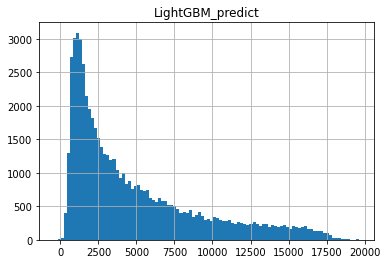

In [86]:
plt.title('LightGBM_predict')
pd.Series(lgbm_predict).hist(bins=100)

<AxesSubplot:title={'center':'target_valid'}>

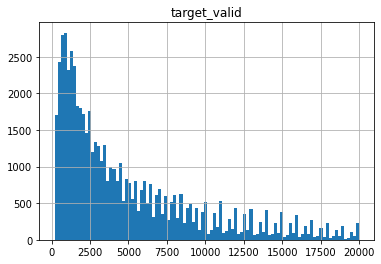

In [87]:
plt.title('target_valid')
target_valid.hist(bins=100)

In [88]:
lgbm_predict[lgbm_predict< 0].shape

(6,)

**Вывод** Отличный результат на дефолтах, метрика в норме, распределение соотвествует таргету.Но есть несколько значений ниже 0.

#### Подбор гиперпараметров Light GBM с использованием GridSearchCV

In [89]:
lgbm = LGBMRegressor()
parametrs = { 'learning_rate' :[0.01, 0.10],
              'max_depth'  : [4,8,12]
             }

In [90]:
%%time
grid = GridSearchCV(lgbm , parametrs, cv=2 , scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)

CPU times: user 45.6 s, sys: 165 ms, total: 45.7 s
Wall time: 36.7 s


GridSearchCV(cv=2, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12]},
             scoring='neg_mean_squared_error')

In [91]:
print('Best hyperparameters are: ',grid.best_params_)
print('Best score is: ',(-1 * grid.best_score_)**0.5)

Best hyperparameters are:  {'learning_rate': 0.1, 'max_depth': 12}
Best score is:  1589.709326299717


rmse не удалось увеличить по сравнению с дефолтными гиперпараметрами.

### CatBoostRegressor  
для кэт нужно указать лишь категориальный фичи, ohe зашито внутри. Используем дефолтные гипер параметры.

In [92]:
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df_cat)

cat_features = features_train.select_dtypes(include='object').columns.to_list()

In [93]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294477 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              294477 non-null  int64 
 1   VehicleType        294477 non-null  object
 2   RegistrationYear   294477 non-null  int64 
 3   Gearbox            294477 non-null  object
 4   Power              294477 non-null  int64 
 5   Kilometer          294477 non-null  int64 
 6   RegistrationMonth  294477 non-null  int64 
 7   FuelType           294477 non-null  object
 8   Repaired           294477 non-null  object
 9   Brand_Model        294477 non-null  object
dtypes: int64(5), object(5)
memory usage: 24.7+ MB


In [94]:
%%time
#2 мин
cat = CatBoostRegressor()
cat.fit(features_train, target_train,cat_features=cat_features, silent=True)
#cat_predict = cat.predict(features_valid)

CPU times: user 4min 58s, sys: 4 s, total: 5min 2s
Wall time: 3min 30s


In [95]:
%%time
cat_predict = cat.predict(features_valid)
print ('RMSE', mean_squared_error(target_valid, cat_predict )**0.5 )

RMSE 1556.3020825106692
CPU times: user 942 ms, sys: 11.1 ms, total: 953 ms
Wall time: 549 ms


In [96]:
# Результаты в в таблицу сохраняем
stats.loc['CatBoost' , 'RMSE'] = int(mean_squared_error(target_valid, cat_predict )**0.5 )
stats.loc['CatBoost' , 'time_predict'] = '2min 38s'
stats.loc['CatBoost' , 'time_fit'] = '499 ms'
stats

,RMSE,time_predict,time_fit
LinReg,2341,15.8 s,87 ms
LigtGBM,1545,5.15 s,597 ms
CatBoost,1556,2min 38s,499 ms


Получили отличный результат.Цель проекта выполнена.

Посмотрим на гистограмме

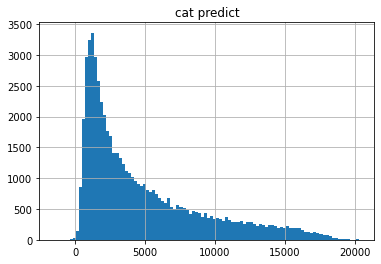

<AxesSubplot:title={'center':'target_valid'}>

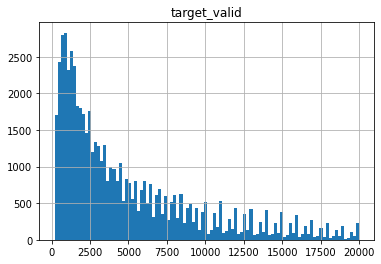

In [97]:
plt.title('cat predict')
pd.Series(cat_predict).hist(bins=100)
plt.show()
plt.title('target_valid')
target_valid.hist(bins=100)



Очень похоже на таргет. Хуже предсказываются большие цены, которые как раз для "оригинальных авто".    
Но все равно есть какие то открицательные значения...хотя их мало очень

In [98]:
cat_predict[cat_predict < 0].shape

(23,)

feature importance  in CatBost

<AxesSubplot:title={'center':'Важность признаков'}>

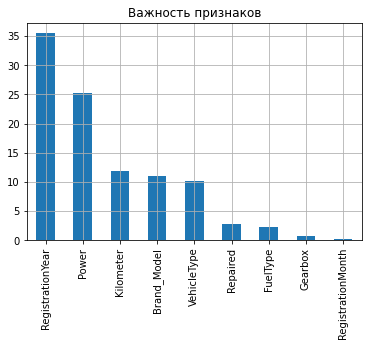

In [99]:
feature_importances = pd.Series(cat.feature_importances_, index=cat.feature_names_).sort_values(ascending=False)
feature_importances.plot(kind='bar',grid=True, title='Важность признаков')


ОТбросим RegistrationMonth	, проверим метрику

In [100]:
df_cat = df_cat.drop(['RegistrationMonth'], axis=1)
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df_cat)
cat_features = features_train.select_dtypes(include='object').columns.to_list()

In [101]:
%%time
#3 мин
cat = CatBoostRegressor()
cat.fit(features_train, target_train,cat_features=cat_features, silent=True)

CPU times: user 4min 54s, sys: 3.17 s, total: 4min 57s
Wall time: 3min 5s


In [102]:
cat_predict = cat.predict(features_valid)
print ('RMSE', mean_squared_error(target_valid, cat_predict )**0.5 )

RMSE 1557.2068641367023


Почти не изменилось значение. 

#### Подбор гипер параметров CatBoost c помощью cat.grid_search

In [103]:
%%time
cat_grid = CatBoostRegressor(cat_features=cat_features)

grid = {
        'depth': [2, 5, 7],
        'l2_leaf_reg': [1, 3],
        'iterations': [100,200],
          }

grid_search_result = cat_grid.grid_search(grid, features_train, target_train,  plot=False)

0:	learn: 6462.6917621	test: 6498.3097700	best: 6498.3097700 (0)	total: 38.6ms	remaining: 3.82s
1:	learn: 6316.7659341	test: 6351.7347870	best: 6351.7347870 (1)	total: 64.3ms	remaining: 3.15s
2:	learn: 6176.9159192	test: 6210.6084894	best: 6210.6084894 (2)	total: 102ms	remaining: 3.3s
3:	learn: 6044.3229038	test: 6076.6443236	best: 6076.6443236 (3)	total: 142ms	remaining: 3.41s
4:	learn: 5913.4587137	test: 5945.1716322	best: 5945.1716322 (4)	total: 170ms	remaining: 3.22s
5:	learn: 5787.0360588	test: 5817.8846523	best: 5817.8846523 (5)	total: 196ms	remaining: 3.06s
6:	learn: 5665.8817995	test: 5695.8923955	best: 5695.8923955 (6)	total: 223ms	remaining: 2.96s
7:	learn: 5548.2327310	test: 5577.5427946	best: 5577.5427946 (7)	total: 253ms	remaining: 2.9s
8:	learn: 5435.7272252	test: 5464.2871407	best: 5464.2871407 (8)	total: 278ms	remaining: 2.81s
9:	learn: 5327.7042637	test: 5355.3279776	best: 5355.3279776 (9)	total: 305ms	remaining: 2.75s
10:	learn: 5224.6713626	test: 5250.9854393	best: 5

In [104]:
grid_search_result['params']

{'depth': 7, 'l2_leaf_reg': 1, 'iterations': 200}

Подбор гиперпараметров не улучшил метрику

## Анализ моделей     


In [105]:
stats

,RMSE,time_predict,time_fit
LinReg,2341,15.8 s,87 ms
LigtGBM,1545,5.15 s,597 ms
CatBoost,1556,2min 38s,499 ms


По времени  быстрее predict и качественнее(меньше RMSE )  у LightGBM(дефолт) , ее и выбираем для тестовой выбоки.

## Проверка выбраной модели на тестовой выборке

In [106]:
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294477 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              294477 non-null  int64   
 1   VehicleType        294477 non-null  category
 2   RegistrationYear   294477 non-null  int64   
 3   Gearbox            294477 non-null  category
 4   Power              294477 non-null  int64   
 5   Kilometer          294477 non-null  int64   
 6   RegistrationMonth  294477 non-null  int64   
 7   FuelType           294477 non-null  category
 8   Repaired           294477 non-null  category
 9   Brand_Model        294477 non-null  category
dtypes: category(5), int64(5)
memory usage: 15.2 MB


In [107]:
features_train, target_train, features_valid, features_test, target_valid, target_test = preparation(df_lgbm)

#объеденим train и валид выборки, чтобы улчучшить предсказания для теста.
features_train = pd.concat([features_train, features_valid],ignore_index=True)
target_train = pd.concat([target_train, target_valid],ignore_index=True)


In [108]:
%%time
# 7 сек

model = LGBMRegressor()
model.fit(features_train, target_train  )
test_predict = model.predict (features_valid)
print ('RMSE', mean_squared_error(target_valid, test_predict )**0.5 )

RMSE 1496.850490602524
CPU times: user 6.06 s, sys: 54.7 ms, total: 6.12 s
Wall time: 4.3 s


**Вывод** На тестовой выборке rmse соотвествует тех. заданию и даже немного улучшилось, скорее всего за счет объеденгения трайн+валид.

In [109]:
# проверим модель на адекватность
model_dummy = DummyRegressor(strategy = 'mean' )

#обучаем на трайн выборке  
model_dummy.fit(features_train, target_train)
predict_dummy = model_dummy.predict(features_test)
print ("RMSE strategy = 'mean'", mean_squared_error(target_test, predict_dummy )**0.5 )

# тоже для медианы
model_dummy = DummyRegressor(strategy = 'median' )
model_dummy.fit(features_train, target_train)
predict_dummy = model_dummy.predict(features_test)
print ("RMSE strategy = 'median'", mean_squared_error(target_test, predict_dummy )**0.5 )

RMSE strategy = 'mean' 4553.905637394545
RMSE strategy = 'median' 4831.988047423211


**Вывод** dummy модель показывает rmse значительно хуже. Наша модель адекватна.


## Общий вывод.   
Данные были загружены.  
Выполенна обработка :отброшены нулевые и около нудевые цены,отброшены слишком ранние года и несуществующие ,так же другие колонки обработы, пропуски заменены на строковые 'nan' .   
Данные подготовлены к ML, для упрощения текста созданы функции по разбивке и ohe кодировке.   
Обучена модель ЛинейнойРегрессии, получено rmse 2341, проведено feature selection, которое ухужшило результат.   
Обучена модель градиентного бустинга LightGBM, получено rmse 1650.  Подбор гиперпараметров не улучшил результат.   
Обучена модель градиентного бустинга CatBoost, получено rmse  1556. Подбор гипер параметров не улучшил результат.   
Выбрана модель LigtGBM  
Проведены тесты на тестовой выборке. Получен результат rmse 1499, что соответсвует ТЗ.   
Также модель проверена на адекватность с помощью dummyRegressor.  
